In [1]:
import warnings
warnings.filterwarnings("ignore") 
import os, time
import pandas as pd
import numpy as np
import random
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, issparse

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color

start = time.perf_counter_ns()
random_seed = 1234
cluster_algorithm = 'leiden'
np.random.seed(random_seed)
random.seed(random_seed)

## Input-Ouput (IO) Options
1. Loading '.h5ad' file
2. Saving output images and '.csv' files in 'output_folder'

In [2]:
from banksy_utils.load_data import load_adata

'''Main tunable variation in running the BANKSY algorithm'''

'''Input File'''
file_path = os.path.join("data", "starmap")
adata_filename = "starmap_BY3_1k.h5ad"

gcm_filename = ""
locations_filename = ""

load_adata_directly = True

'''Saving output figures'''
save_fig = False

output_folder = os.path.join(os.getcwd(), 'data', 'starmap', 'tmp_png', f'{cluster_algorithm}', f'seed{random_seed}')

# Colour map
c_map = 'tab20'

coord_keys = ('x', 'y', 'spatial')
num_clusters = 7
sample = 'starmap'

raw_y, raw_x, adata = load_adata(file_path,
                                 load_adata_directly,
                                 adata_filename,
                                 gcm_filename,
                                 locations_filename,
                                 coord_keys)

adata.var_names_make_unique()

Looking for data\starmap\starmap_BY3_1k.h5ad
Attemping to read Annadata directly
Anndata file successfully loaded!
Attempting to concatenate spatial x-y under adata.obsm[spatial]
Concatenation success!


## Initial Round of filtering by cell-count and gene counts (Skipped)
1. Define 'min_count' and 'max_count' for filtering genes by cell-count
2. 'MT-filter' for filtering MT-genes
3. 'n_top_genes' for selecting the top n HVGs or SVGs

Note that: For STARmap, we skip this step as the data matrix loaded has already been preprocessed using the ipython script provided by the authors

### Load Manual annotations from datafile

In [3]:
'''Load manual annotations'''
adata = adata[adata.obs["cluster_name"].notnull()]

annotations =  pd.read_csv(os.path.join(file_path, "Starmap_BY3_1k_meta_annotated_18oct22.csv"))

manual_labels =  "smoothed_manual" # Ground truth annotations in pd.DataFrame
annotation_key = 'manual_annotations' # Key to access annotations in adata.obs[annotation_keys]

print(annotations.loc[:,manual_labels ])
adata.obs[annotation_key] = annotations.loc[:,manual_labels ].values
adata.obs[annotation_key] = adata.obs[annotation_key].astype('category')
print(adata.obs[annotation_key])

# Add spatial coordinates to '.obsm' attribute
adata.obsm[coord_keys[2]] = pd.concat([adata.obs[coord_keys[0]], adata.obs[coord_keys[1]]], axis=1).to_numpy()

Trying to set attribute `.obs` of view, copying.


0         L6
1         L4
2       L2/3
3         L6
4         L5
        ... 
1202      L6
1203      L6
1204    L2/3
1205      L1
1206      L4
Name: smoothed_manual, Length: 1207, dtype: object
8         L6
9         L4
12      L2/3
14        L6
15        L5
        ... 
1381      L6
1382      L6
1384    L2/3
1386      L1
1388      L4
Name: manual_annotations, Length: 1207, dtype: category
Categories (7, object): ['HPC', 'L1', 'L2/3', 'L4', 'L5', 'L6', 'cc']


# Specifying parameters for BANKSY

In [4]:
resolutions = [.9] # clustering resolution for Leiden clustering

pca_dims = [20] # number of dimensions to keep after PCA

lambda_list = [.8] # lambda

k_geom = 15 # 15 spatial neighbours

max_m = 1 # use AGF

nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"

# Initialize Banksy Object


Median distance to closest cell = 151.73174484023787

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.08 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 427.6671712182396, mode = 478.9093457661985

---- Ran plot_edge_histogram in 0.06 s ----


Edge weights (weights between cells): median = 0.058031415192358084, mode = 0.030729986333754854

---- Ran plot_edge_histogram in 0.05 s ----

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran theta_from_spatial_graph in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.07 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 600.1121978555407, mode = 667.7356769990661

---- Ran plot_edge_histogram in 0.05 s ----


Edge

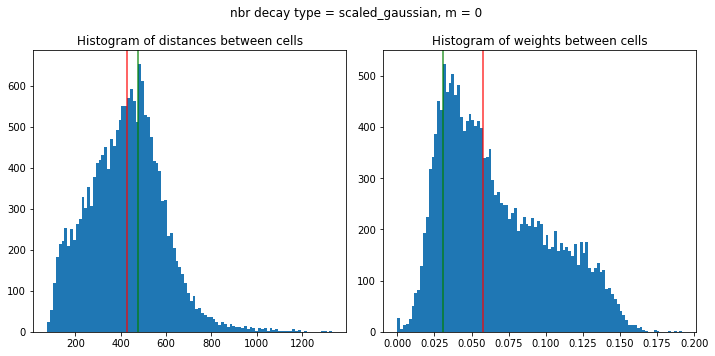

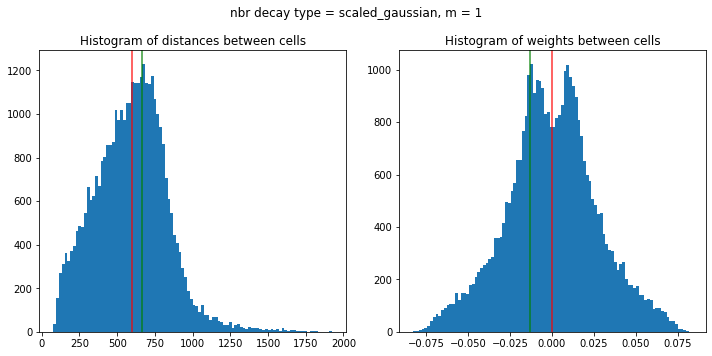

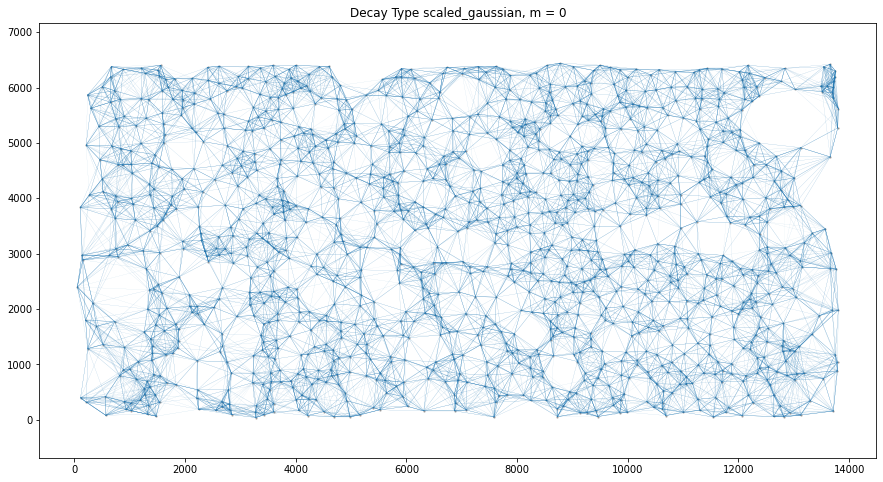

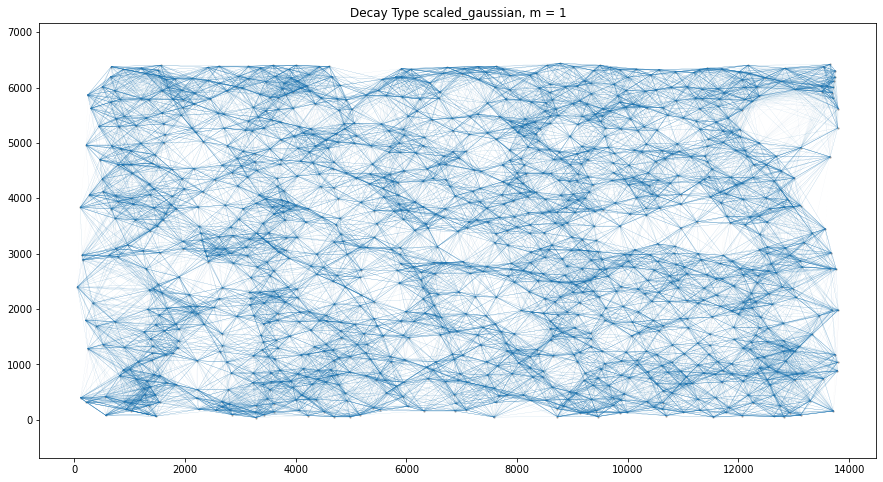

In [5]:
banksy_dict = initialize_banksy(
    adata,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False,
    plt_theta=False,
)

# Run BANKSY using defined parameters

Runtime Jan-03-2024-16-43

1020 genes to be analysed:
Gene List:
Index(['1110008F13Rik', '1110008P14Rik', '1700019D03Rik', '1700086L19Rik',
       '2810468N07Rik', '2900055J20Rik', '2900092D14Rik', '3110035E14Rik',
       '3632451O06Rik', '6330403K07Rik',
       ...
       'Zcchc12', 'Zdhhc24', 'Zfand6', 'Zfp57', 'Zfp637', 'Zfp975', 'Zmat4',
       'Zmym1', 'Znhit3', 'Znrd1'],
      dtype='object', length=1020)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <1207x1207 sparse matrix of type '<class 'numpy.float64'>'
	with 18105 stored elements in Compressed Sparse Row format>, 1: <1207x1207 sparse matrix of type '<class 'numpy.complex128'>'
	with 36210 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.46 | Std: 1.74
Size of Nbr | Shape: (1207, 1020)
Top 3 entries of Nbr Mat:

[[0.43563741 0.61231477 0.25562053]
 [0.22100112 0.49943188 0.34561754]
 [0.4527257  0.87557976 0.49508222]]

AGF matrix | Mean:

,decay,lambda_param,num_pcs,resolution,num_labels,labels,adata,ari
scaled_gaussian_pc20_nc0.80_r0.90,scaled_gaussian,0.8,20,0.9,7,"Label object:\nNumber of labels: 7, number of ...",[[[View of AnnData object with n_obs × n_vars ...,0.726197


Anndata AxisArrays with keys: reduced_pc_20


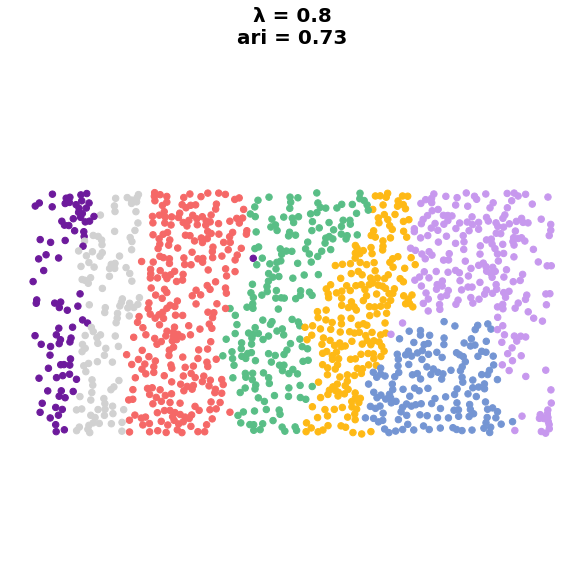

In [6]:
results_df = run_banksy_multiparam(
    adata,
    banksy_dict,
    lambda_list,
    resolutions,
    color_list = spagcn_color,
    max_m = max_m,
    filepath = output_folder,
    key = coord_keys,
    pca_dims = pca_dims,
    annotation_key = annotation_key,
    max_labels = num_clusters,
    cluster_algorithm = cluster_algorithm,
    match_labels = False,
    savefig = False,
    add_nonspatial = False,
    variance_balance = False,
)

## Optional Step (not used in paper): Refine Clusters 
Demonstration of how we can smooth labels based on the majority of its neighbourhood. 
Note that this is **not** used in our main manuscript. 
All algorithms run on the STARmap benchmark were performed without this refinement step

Refine only once

Number of nodes swapped 13 | ratio: 0.011
Total Entropy: 0.1
Refined once | Total Entropy: 0.1
scaled_gaussian_pc20_nc0.80_r0.90 saved refined plot at C:\Users\chousn\Desktop\BANKSY_py_REVIEW-main\data\starmap\tmp_png\leiden\seed1234
Time taken for refinement = 0.01 min
BANKSY runtime = 0.089 mins


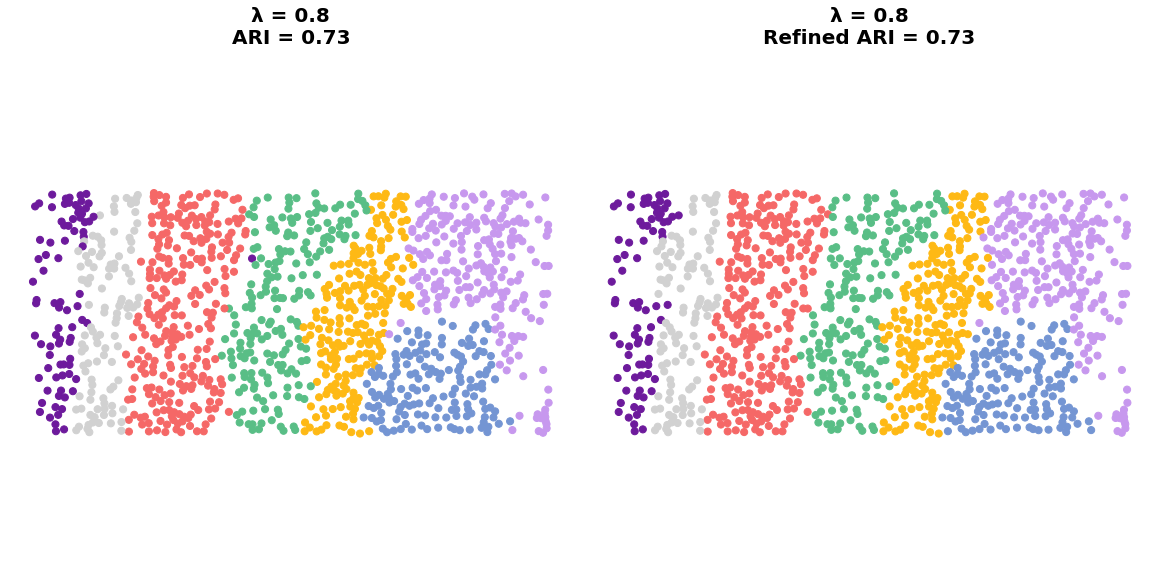

In [7]:
from banksy_utils.refine_clusters import refine_clusters

results_df = refine_clusters(adata,
                             results_df,
                             coord_keys=coord_keys,
                             color_list=spagcn_color,
                             savefig=True,
                             output_folder=output_folder,
                             refine_method='once',
                             annotation_key=annotation_key,
                             num_neigh=6)

run_time = (time.perf_counter_ns() - start) * 1e-9
print(f"BANKSY runtime = {round(run_time / 60, 3)} mins")
results_df.to_csv(os.path.join(output_folder, 'results.csv'))